# Societe Generale Complaint Tracker

In [1]:
import pandas as panda

from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, \
    confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plot
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns


from numpy import bincount, linspace, mean, std, arange, squeeze

import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
test_data_path ='dataset/test_all_merged_1.csv'
train_data_path = 'dataset/train_all_merged_1.csv'
sample_submission_path = 'dataset/sample_submission.csv'
test_complaint_reason_path = 'dataset/test_data_complaint_reason.csv'
train_complaint_reason_path = 'dataset/train_data_complaint_reason.csv'


In [3]:
train_data = panda.read_csv(train_data_path)
train_data.drop(columns = ['complaint_reason_x','Unnamed: 0'], axis = 1, inplace = True)
train_data.rename(columns = {'complaint_reason_y':'complaint_reason'}, inplace = True)
train_data.columns.tolist()

['complaint_id',
 'complaint_reason_encoded',
 'date_received',
 'transaction_type',
 'complaint_reason',
 'company_response',
 'date_sent_to_company',
 'complaint_status',
 'consumer_disputes',
 'consumer_complaint_summary',
 'days_passed_since_complaint_received',
 'days_since_complaint_sent_to_company',
 'Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Student loan',
 'Vehicle loan or lease',
 'Virtual currency',
 '0',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 'Company believes complai

In [4]:
train_data.head()

,complaint_id,complaint_reason_encoded,date_received,transaction_type,complaint_reason,company_response,date_sent_to_company,complaint_status,consumer_disputes,consumer_complaint_summary,...,Company believes complaint relates to a discontinued policy or procedure,Company believes complaint represents an opportunity for improvement to better serve consumers,Company believes it acted appropriately as authorized by contract or law,Company believes the complaint is the result of a misunderstanding,Company can't verify or dispute the facts in the complaint,Company chooses not to provide a public response,Company disputes the facts presented in the complaint,Company has responded to the consumer and the CFPB and chooses not to provide a public response,encoded_consumer_disputes,y
0,Tr-1,8,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",Company has responded to the consumer and the ...,11/11/2015,Closed with explanation,Yes,"Seterus, Inc a déposé un faux rapport auprès d...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
1,Tr-2,13,7/7/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,7/7/2015,Closed with non-monetary relief,No,XX / XX / XXXX La requête en faillite n ° XXXX...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
2,Tr-3,21,5/7/2015,Bank account or service,Using a debit or ATM card,Company has responded to the consumer and the ...,5/7/2015,Closed with explanation,No,"El XXXX / XXXX / 15, estaba preparando el vuel...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,Tr-4,22,11/12/2016,Debt collection,Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...,11/12/2016,Closed with explanation,No,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Tr-5,24,9/29/2016,Credit card,Payoff process,Company has responded to the consumer and the ...,9/29/2016,Closed with explanation,No,J'ai obtenu un compte de crédit de soins pour ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [5]:
tfidf = TfidfVectorizer()
train_complaint_reason_vector = tfidf.fit_transform(train_data.complaint_reason.values)
td = panda.DataFrame(train_complaint_reason_vector.toarray())
td.columns = ['train_'+str(i) for i in td.columns.tolist() ]
train_data = panda.concat([train_data, td], axis = 1)
train_data.head()

,complaint_id,complaint_reason_encoded,date_received,transaction_type,complaint_reason,company_response,date_sent_to_company,complaint_status,consumer_disputes,consumer_complaint_summary,...,train_222,train_223,train_224,train_225,train_226,train_227,train_228,train_229,train_230,train_231
0,Tr-1,8,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",Company has responded to the consumer and the ...,11/11/2015,Closed with explanation,Yes,"Seterus, Inc a déposé un faux rapport auprès d...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Tr-2,13,7/7/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,7/7/2015,Closed with non-monetary relief,No,XX / XX / XXXX La requête en faillite n ° XXXX...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Tr-3,21,5/7/2015,Bank account or service,Using a debit or ATM card,Company has responded to the consumer and the ...,5/7/2015,Closed with explanation,No,"El XXXX / XXXX / 15, estaba preparando el vuel...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tr-4,22,11/12/2016,Debt collection,Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...,11/12/2016,Closed with explanation,No,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tr-5,24,9/29/2016,Credit card,Payoff process,Company has responded to the consumer and the ...,9/29/2016,Closed with explanation,No,J'ai obtenu un compte de crédit de soins pour ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
## lets prepare our x data set values

columns_not_required = [
'complaint_id',\
'date_received',\
'transaction_type',\
'complaint_reason',\
'company_response',\
'date_sent_to_company',\
'complaint_status',\
'consumer_disputes',\
'consumer_complaint_summary',\
'Unnamed: 0', \
'complaint_reason.1', 
'complaint_reason_x',\
'complaint_reason_y' ,\
'y', \
# 'complaint_reason_encoded'
]


x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]

x.head()

,complaint_reason_encoded,days_passed_since_complaint_received,days_since_complaint_sent_to_company,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",...,train_222,train_223,train_224,train_225,train_226,train_227,train_228,train_229,train_230,train_231
0,8,1166,1166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,1293,1293,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,1354,1354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,799,799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,843,843,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
td.shape, train_data.shape, train_complaint_reason_vector.shape

((43266, 232), (43266, 298), (43266, 232))

In [8]:
y = train_data[['y']]
y.head()

,y
0,0
1,1
2,0
3,0
4,0


In [9]:
target_dist = panda.DataFrame(np.bincount(y.values.ravel()), np.unique(y.values)).reset_index()
target_dist.columns = ['labels','occurences']
target_dist

,labels,occurences
0,0,34300
1,1,5018
2,2,2818
3,3,809
4,4,321


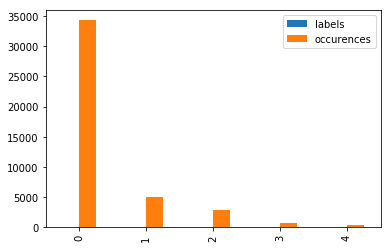

In [10]:
target_dist.plot(kind='bar')
plot.show()

In [11]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [12]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
#     print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
        
    with predict_proba_timer:
        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            y_probability = gridsearch.predict_proba(x_test)
#             false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
#             response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
#             response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = None
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['best_estimator'] = search.best_estimator_
    
    
    return response

In [13]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)

In [14]:
print("label counts in y train %s" %_y_train['y'].value_counts())
print("label counts in y test %s" %_y_test['y'].value_counts())

label counts in y train 0    24010
1     3512
2     1973
3      566
4      225
Name: y, dtype: int64
label counts in y test 0    10290
1     1506
2      845
3      243
4       96
Name: y, dtype: int64


In [132]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
_x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [15]:
## its time to run my pipeline and classification models

from sklearn.ensemble import AdaBoostClassifier

## we will add more classifiers in round2
classifiers = [
#     Perceptron(random_state = 1),
#     LogisticRegression(random_state = 1),
#     AdaBoostClassifier(RandomForestClassifier(random_state = 1, n_estimators = 10, criterion='entropy'), n_estimators = 400, learning_rate = 0.1),
#     AdaBoostClassifier(DecisionTreeClassifier(random_state = 1, max_depth = 8, criterion='entropy'), n_estimators = 400, learning_rate = 0.1),
    DecisionTreeClassifier(),

#     RandomForestClassifier(random_state = 1),
#     KNeighborsClassifier(metric = 'minkowski'),
#     AdaBoostClassifier(RidgeClassifier(random_state = 123,alpha=1.2, max_iter=100), 
#                            n_estimators = 400, learning_rate = 0.1, algorithm='SAMME'),
    
]


classifier_names = [
#             'perceptron',
#             'logisticregression',
            'decisiontreeclassifier',
#             'randomforestclassifier',
#             'kneighborsclassifier',
#             'ridge'
]

classifier_param_grid = [
            
#             {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
#             {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
#     {}
#             {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
#             {'kneighborsclassifier__n_neighbors':[4,6,10]},
#             {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]}
    
]

Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
Grid Search Best score  0.7172324339891947
Code block 'training' took(HH:MM:SS): 0:04:02.833496
Code block 'testing' took(HH:MM:SS): 0:00:00.090244
F1 score 0.7232428016975526
Classification report  
               precision    recall  f1-score   support

           0       0.80      0.99      0.89     10290
           1       0.45      0.04      0.07      1506
           2       0.56      0.12      0.19       845
           3       0.71      0.02      0.04       243
           4       0.00      0.00      0.00        96

   micro avg       0.80      0.80      0.80     12980
   macro avg       0.51      0.23      0.24     12980
weighted avg       0.74      0.80      0.72     12980



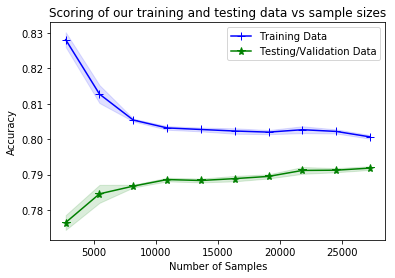

Code block 'learning_curve' took(HH:MM:SS): 0:00:49.786902
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.060315
Code block 'overalltime' took(HH:MM:SS): 0:04:52.936889
292936.88862239616


In [16]:
timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

#         cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=12)
        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = cv,score = 'f1_weighted')

        _y_prediction = result['_y_prediction']
        
#         cf = panda.crosstab(
#             panda.Series(_y_test, name='Actual'),
#             panda.Series(_y_prediction, name = 'Prediction'),
#             margins = True
#         )

#         print(cf)
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction, labels = _y_test['y'].values)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
#         model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
#         model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
#         model_metrics[model_name]['roc_curve'] = result['roc_curve']
        model_metrics[model_name]['best_estimator'] = result['best_estimator']
        
        
print(timer.took)


#### There are some observations we can make: 

#### 1. DecisionTreeClassifier gives perfect predictions gives  best f1 score. And we have similar scores for testing and training data , suggesting less variations/overfitting


#### We will use both these classifiers to make a prediction on the train set

In [17]:
# model_estimates = panda.DataFrame(model_metrics).transpose()

model_metrics

{'decisiontreeclassifier': {'confusion_matrix': array([[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0, 10174]], dtype=int64),
  'training_time': 242833.4959406945,
  'testing_time': 90.24395655282547,
  'learning_curve_time': 49786.90167839241,
  'f1_score': 0.7232428016975526,
  'best_estimator': Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weigh

In [18]:
decision_tree_model =model_metrics['decisiontreeclassifier']['best_estimator']

# k_neighbor_model =model_metrics['kneighborsclassifier']['best_estimator']

#### At this point our models are ready using which we can predict on our test data. Note since we used  a pipeline, model has the built in scaling.

### Prepare the test data and run prediction


#### remember to check for column dimension

In [19]:
test_data = panda.read_csv(test_data_path)
test_data.shape

(18543, 66)

In [20]:
test_data.columns.values

array(['Unnamed: 0', 'complaint_id', 'complaint_reason_x',
       'complaint_reason_encoded', 'date_received', 'transaction_type',
       'complaint_reason_y', 'company_response', 'date_sent_to_company',
       'consumer_disputes', 'consumer_complaint_summary',
       'days_passed_since_complaint_received',
       'days_since_complaint_sent_to_company', 'Bank account or service',
       'Checking or savings account', 'Consumer Loan', 'Credit card',
       'Credit card or prepaid card', 'Credit reporting',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection',
       'Money transfer, virtual currency, or money service',
       'Money transfers', 'Mortgage', 'Other financial service',
       'Payday loan', 'Payday loan, title loan, or personal loan',
       'Prepaid card', 'Student loan', 'Vehicle loan or lease',
       'Virtual currency', '0', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16'

In [21]:
test_data.drop(columns = ['complaint_reason_x','Unnamed: 0'], axis = 1, inplace = True)
test_data.rename(columns ={'complaint_reason_y':'complaint_reason'}, inplace = True)

test_data.head()

,complaint_id,complaint_reason_encoded,date_received,transaction_type,complaint_reason,company_response,date_sent_to_company,consumer_disputes,consumer_complaint_summary,days_passed_since_complaint_received,...,Company believes complaint is the result of an isolated error,Company believes complaint relates to a discontinued policy or procedure,Company believes complaint represents an opportunity for improvement to better serve consumers,Company believes it acted appropriately as authorized by contract or law,Company believes the complaint is the result of a misunderstanding,Company can't verify or dispute the facts in the complaint,Company chooses not to provide a public response,Company disputes the facts presented in the complaint,Company has responded to the consumer and the CFPB and chooses not to provide a public response,encoded_consumer_disputes
0,Te-1,5,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,XXXX / XXXX / 16 I called Citibank to open a c...,885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,Te-2,24,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,I'm struggling financially. I called and I off...,1007,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Te-3,13,3/23/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,3/23/2016,No,"In XXXX of 2015, an automatic payment was conf...",1033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,Te-4,4,6/26/2017,Student loan,Dealing with your lender or servicer,Company has responded to the consumer and the ...,6/26/2017,No,"I submitted a request to XXXX, which is my cur...",573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,Te-5,13,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,A state tax lien was filed against me XXXX / X...,982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [22]:
tfidf_test = TfidfVectorizer(vocabulary = tfidf.vocabulary_)
test_complaint_reason_vector = tfidf_test.fit_transform(test_data.complaint_reason.values)

# test_data = panda.concat([test_data, panda.DataFrame(test_complaint_reason_vector.toarray())], axis = 1)
# test_data.head()
test_complaint_reason_vector.shape

(18543, 232)

In [23]:
test_data.head()

,complaint_id,complaint_reason_encoded,date_received,transaction_type,complaint_reason,company_response,date_sent_to_company,consumer_disputes,consumer_complaint_summary,days_passed_since_complaint_received,...,Company believes complaint is the result of an isolated error,Company believes complaint relates to a discontinued policy or procedure,Company believes complaint represents an opportunity for improvement to better serve consumers,Company believes it acted appropriately as authorized by contract or law,Company believes the complaint is the result of a misunderstanding,Company can't verify or dispute the facts in the complaint,Company chooses not to provide a public response,Company disputes the facts presented in the complaint,Company has responded to the consumer and the CFPB and chooses not to provide a public response,encoded_consumer_disputes
0,Te-1,5,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,XXXX / XXXX / 16 I called Citibank to open a c...,885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,Te-2,24,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,I'm struggling financially. I called and I off...,1007,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Te-3,13,3/23/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,3/23/2016,No,"In XXXX of 2015, an automatic payment was conf...",1033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,Te-4,4,6/26/2017,Student loan,Dealing with your lender or servicer,Company has responded to the consumer and the ...,6/26/2017,No,"I submitted a request to XXXX, which is my cur...",573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,Te-5,13,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,A state tax lien was filed against me XXXX / X...,982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [24]:
test_x = test_data[[i for i in test_data.columns.tolist() if i not in columns_not_required]]

In [25]:
set(x.columns.tolist()) - set(test_x.columns.tolist())

{'train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_101',
 'train_102',
 'train_103',
 'train_104',
 'train_105',
 'train_106',
 'train_107',
 'train_108',
 'train_109',
 'train_11',
 'train_110',
 'train_111',
 'train_112',
 'train_113',
 'train_114',
 'train_115',
 'train_116',
 'train_117',
 'train_118',
 'train_119',
 'train_12',
 'train_120',
 'train_121',
 'train_122',
 'train_123',
 'train_124',
 'train_125',
 'train_126',
 'train_127',
 'train_128',
 'train_129',
 'train_13',
 'train_130',
 'train_131',
 'train_132',
 'train_133',
 'train_134',
 'train_135',
 'train_136',
 'train_137',
 'train_138',
 'train_139',
 'train_14',
 'train_140',
 'train_141',
 'train_142',
 'train_143',
 'train_144',
 'train_145',
 'train_146',
 'train_147',
 'train_148',
 'train_149',
 'train_15',
 'train_150',
 'train_151',
 'train_152',
 'train_153',
 'train_154',
 'train_155',
 'train_156',
 'train_157',
 'train_158',
 'train_159',
 'train_16',
 'train_160',
 'train_161',
 'train_162',
 't

In [26]:
d=panda.DataFrame(test_complaint_reason_vector.toarray())
d.columns = ['test_'+str(i) for i in d.columns.tolist()]
test_x.shape,d.head()


((18543, 56),
    test_0    test_1  test_2  test_3  test_4  test_5  test_6  test_7  test_8  \
 0     0.0  0.359207     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1     0.0  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2     0.0  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3     0.0  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4     0.0  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
    test_9    ...     test_222  test_223  test_224  test_225  test_226  \
 0     0.0    ...          0.0       0.0       0.0  0.000000       0.0   
 1     0.0    ...          0.0       0.0       0.0  0.000000       0.0   
 2     0.0    ...          0.0       0.0       0.0  0.000000       0.0   
 3     0.0    ...          0.0       0.0       0.0  0.400514       0.0   
 4     0.0    ...          0.0       0.0       0.0  0.000000       0.0   
 
    test_227  test_228  test_229  test_230  test_231  
 0 

In [88]:
56+228


284

In [27]:
tt = panda.concat([test_x,d], axis = 1)

In [28]:
test_x.shape,tt.shape, _x_train.shape, x.shape,test_complaint_reason_vector.shape, train_complaint_reason_vector.shape

((18543, 56),
 (18543, 288),
 (30286, 288),
 (43266, 288),
 (18543, 232),
 (43266, 232))

In [29]:
set(x.columns.tolist()) - set(tt.columns.tolist())

{'train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_101',
 'train_102',
 'train_103',
 'train_104',
 'train_105',
 'train_106',
 'train_107',
 'train_108',
 'train_109',
 'train_11',
 'train_110',
 'train_111',
 'train_112',
 'train_113',
 'train_114',
 'train_115',
 'train_116',
 'train_117',
 'train_118',
 'train_119',
 'train_12',
 'train_120',
 'train_121',
 'train_122',
 'train_123',
 'train_124',
 'train_125',
 'train_126',
 'train_127',
 'train_128',
 'train_129',
 'train_13',
 'train_130',
 'train_131',
 'train_132',
 'train_133',
 'train_134',
 'train_135',
 'train_136',
 'train_137',
 'train_138',
 'train_139',
 'train_14',
 'train_140',
 'train_141',
 'train_142',
 'train_143',
 'train_144',
 'train_145',
 'train_146',
 'train_147',
 'train_148',
 'train_149',
 'train_15',
 'train_150',
 'train_151',
 'train_152',
 'train_153',
 'train_154',
 'train_155',
 'train_156',
 'train_157',
 'train_158',
 'train_159',
 'train_16',
 'train_160',
 'train_161',
 'train_162',
 't

In [30]:

from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(tt)

In [31]:
y_predict = decision_tree_model.predict(scaled_x)

In [32]:
np.bincount(y_predict)

array([17102,   795,   646], dtype=int64)

In [33]:
submission_data = panda.read_csv(sample_submission_path)

submission_data.head()

,Complaint-ID,Complaint-Status
0,Te-1,Closed with explanation
1,Te-2,Closed with explanation
2,Te-3,Closed with explanation
3,Te-4,Closed with explanation
4,Te-5,Closed with explanation


In [34]:
#lets apply encoding on our target columns

target_dict = {
    
    'Closed with explanation':0,
    'Closed with non-monetary relief':1,
    'Closed with monetary relief':2,
    'Closed':3,
    'Untimely response':4
    
}


target_dict_reverse = {
    
    0:'Closed with explanation',
    1:'Closed with non-monetary relief',
    2:'Closed with monetary relief',
    3:'Closed',
    4:'Untimely response'
    
}
predict = panda.DataFrame({'y':y_predict})
predict.head(45)

,y
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,1


In [35]:
predict['Complaint-Status'] = predict.y.apply(lambda x:target_dict_reverse.get(x))

In [36]:
predict.head()

,y,Complaint-Status
0,0,Closed with explanation
1,0,Closed with explanation
2,0,Closed with explanation
3,0,Closed with explanation
4,0,Closed with explanation


In [37]:
predict['Complaint-ID'] = test_data['complaint_id']

predict.drop(['y'], axis=1, inplace=True)
predict.head(25)

,Complaint-Status,Complaint-ID
0,Closed with explanation,Te-1
1,Closed with explanation,Te-2
2,Closed with explanation,Te-3
3,Closed with explanation,Te-4
4,Closed with explanation,Te-5
5,Closed with explanation,Te-6
6,Closed with explanation,Te-7
7,Closed with explanation,Te-8
8,Closed with non-monetary relief,Te-9
9,Closed with non-monetary relief,Te-10


In [38]:
predict[['Complaint-ID','Complaint-Status']].to_csv('dataset/submission_round11_repeated_cv_decision_tree.csv', index = False)